In [281]:
import pandas as pd
import time
from datetime import datetime
from datetime import datetime
from collections import Counter
import os
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Conv1D, Flatten, Concatenate, concatenate, Input
from tensorflow.keras.layers import Reshape, GaussianNoise
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Input, LocallyConnected1D, Activation
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, GaussianDropout, AlphaDropout, GaussianNoise
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adamax, Adadelta
from tensorflow.keras.utils import plot_model
from keras.regularizers import l1,l2


from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt
import math

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import scipy
import scipy.signal
import scipy.io as io
import scipy.ndimage as nd
import numpy as np
from sklearn.preprocessing import normalize, scale
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
warnings.warn("deprecated", DeprecationWarning)
import sys

In [67]:
import seaborn as sns

## Data preprocessing

In [2]:
df = pd.read_csv("./CleanedData/315_GN_FA.csv")

In [3]:
df.head()

,Sensor-Company-Model,Species,Sample type,Sample number,Wet lab_ID,Genotype,Seed colour,Scan number,Wetlab method (FA profile),Lab,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,FOSS-DS2500,Groundnut,Whole grain,VB-308,GG 20,GG 20,Virginia bunch,1,ILRI,ILRI,...,0.835126,0.838436,0.841563,0.844404,0.846900,0.849063,0.850849,0.852267,0.853419,0.854451
1,FOSS-DS2500,Groundnut,Whole grain,VB-309,GPBD 4,GPBD 4,Virginia bunch,1,ILRI,ILRI,...,0.797907,0.800653,0.803149,0.805312,0.807149,0.808705,0.809886,0.810661,0.811119,0.811405
2,FOSS-DS2500,Groundnut,Whole grain,VB-303,ICGV 00350,ICGV 00350,Virginia bunch,1,ILRI,ILRI,...,0.850930,0.853847,0.856608,0.859062,0.861106,0.862773,0.864070,0.865044,0.865740,0.866232
3,FOSS-DS2500,Groundnut,Whole grain,VB-304,ICGV 00351,ICGV 00351,Virginia bunch,1,ILRI,ILRI,...,0.836972,0.839769,0.842374,0.844672,0.846588,0.848123,0.849286,0.850153,0.850766,0.851170
4,FOSS-DS2500,Groundnut,Whole grain,VB-300,ICGV 02266,ICGV 02266,Virginia bunch,1,ILRI,ILRI,...,0.810729,0.813243,0.815585,0.817713,0.819593,0.821209,0.822496,0.823470,0.824176,0.824711


In [127]:
df.shape

(315, 1050)

In [5]:
df.dtypes

Sensor-Company-Model     object
Species                  object
Sample type              object
Sample number            object
Wet lab_ID               object
                         ...   
2490                    float64
2492                    float64
2494                    float64
2496                    float64
2498                    float64
Length: 1064, dtype: object

In [6]:
#Correlation matrix
df.loc[:,'400':].corr()

,400,402,404,406,408,410,412,414,416,418,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
400,1.000000,0.999876,0.999535,0.999034,0.998427,0.997725,0.996894,0.995905,0.994753,0.993452,...,0.325990,0.323699,0.321599,0.319648,0.317864,0.316262,0.314825,0.313525,0.312333,0.311251
402,0.999876,1.000000,0.999888,0.999586,0.999147,0.998594,0.997911,0.997069,0.996063,0.994903,...,0.320104,0.317789,0.315665,0.313691,0.311886,0.310268,0.308819,0.307509,0.306309,0.305218
404,0.999535,0.999888,1.000000,0.999901,0.999637,0.999238,0.998701,0.998008,0.997151,0.996138,...,0.315352,0.313011,0.310860,0.308861,0.307034,0.305399,0.303936,0.302615,0.301405,0.300305
406,0.999034,0.999586,0.999901,1.000000,0.999914,0.999672,0.999283,0.998737,0.998028,0.997161,...,0.311524,0.309155,0.306977,0.304951,0.303102,0.301449,0.299974,0.298641,0.297420,0.296309
408,0.998427,0.999147,0.999637,0.999914,1.000000,0.999920,0.999682,0.999282,0.998718,0.997995,...,0.308422,0.306027,0.303822,0.301770,0.299899,0.298230,0.296742,0.295398,0.294167,0.293046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,0.316262,0.310268,0.305399,0.301449,0.298230,0.295465,0.292801,0.290089,0.287463,0.285038,...,0.999664,0.999796,0.999891,0.999954,0.999989,1.000000,0.999990,0.999960,0.999910,0.999839
2492,0.314825,0.308819,0.303936,0.299974,0.296742,0.293966,0.291291,0.288569,0.285933,0.283497,...,0.999551,0.999704,0.999819,0.999902,0.999958,0.999990,1.000000,0.999990,0.999959,0.999906
2494,0.313525,0.307509,0.302615,0.298641,0.295398,0.292613,0.289932,0.287202,0.284557,0.282113,...,0.999427,0.999599,0.999734,0.999835,0.999909,0.999960,0.999990,1.000000,0.999989,0.999956
2496,0.312333,0.306309,0.301405,0.297420,0.294167,0.291373,0.288684,0.285947,0.283295,0.280844,...,0.999288,0.999478,0.999631,0.999751,0.999842,0.999910,0.999959,0.999989,1.000000,0.999988


<AxesSubplot:>

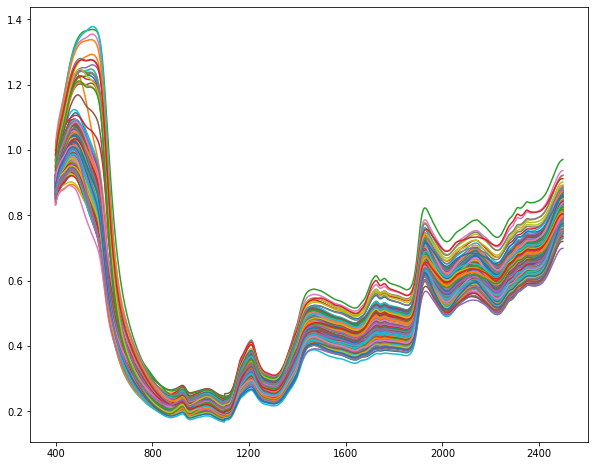

In [10]:
#Visualize spectra
plt.rcParams["figure.figsize"]=[10,8]
df.loc[:,'400':].T.plot(kind='line',legend=False)

<AxesSubplot:xlabel='Oleic Acid', ylabel='Count'>

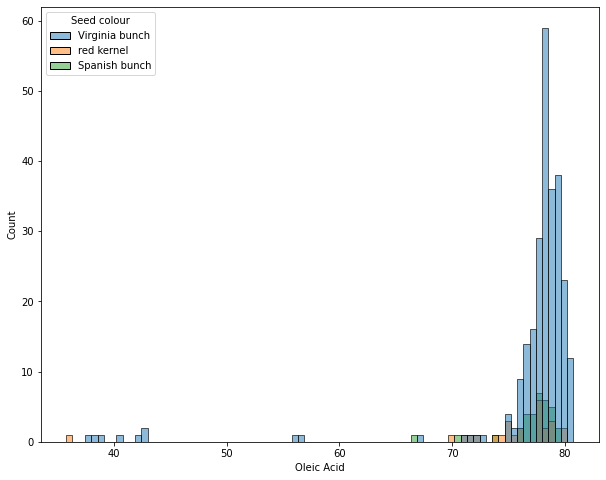

In [75]:
#Visualize distribution of the target
sns.histplot(x='Oleic Acid',data=df,hue='Seed colour')

In [15]:
#statistics
df["Oleic Acid"].describe()

count    315.000000
mean      76.842610
std        6.517218
min       35.777000
25%       77.178000
50%       78.225000
75%       79.073500
max       80.772000
Name: Oleic Acid, dtype: float64

In [97]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
def calculate_vif(df, features):    
    """
    Computes the variant inflation factor (VIF). VIF allows you to determine 
    the strength of the correlation between the various independent variables. 
    It is calculated by taking a variable and regressing it against every other variables
    """
    vif, tolerance = {}, {}
    R2 = []
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        #LR = LinearRegression()
        #LR.fit(X,y)
        r2 = Ridge().fit(X, y).score(X, y)  
        R2.append(r2)
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return R2, pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [98]:
fs = list(df.loc[:,'400':].columns)
r2, vifs = calculate_vif(df, fs)

In [99]:
print(min(r2),max(r2))

0.9712869262179964 0.9993840125274749


In [100]:
selected_feat=list(vifs.nsmallest(25,'VIF').index)

In [114]:
from RENT import RENT, stability
my_C_params = [0.1, 1, 10]
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

model = RENT.RENT_Regression(data=df.loc[:,'400':], 
                                target=df['Oleic Acid'], 
                                feat_names=df.loc[:,'400':].columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=100,
                                random_state=0,
                                verbose=1)

data dimension: (315, 1050)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (315,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1


In [116]:
cv_score, cv_zeros, cv_harmonic_mean = model.get_cv_matrices()
cv_score

Scores,0.1,1.0,10.0
0.00,-0.538891,-0.538891,-0.538891
0.10,-0.213472,-4.150883,-1.082384
0.25,NaN,-0.669186,-3.154592
0.50,NaN,0.131002,-0.752911
0.75,NaN,0.182687,0.002438
0.90,NaN,-0.116303,0.391315
1.00,NaN,-0.110063,0.124778


In [115]:
selected_features = model.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)
selected_features

SystemExit: Run train() first!

In [37]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    input_data = input_data.copy()
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return data_msc

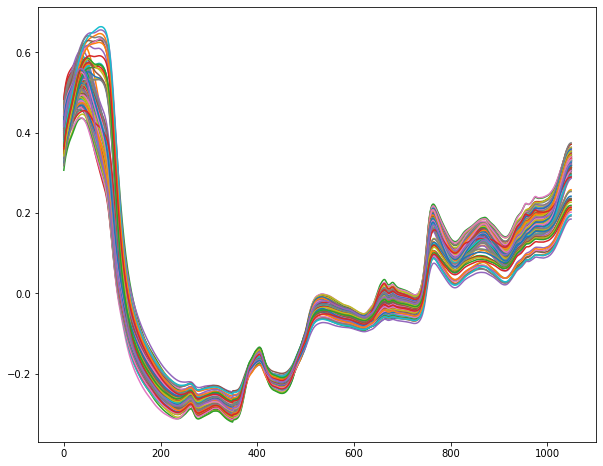

In [21]:
#Visualize spectra MSC
df_msc = msc(df.loc[:,'400':].to_numpy())
_= plt.plot(df_msc.T)

In [38]:
def snv(input_data):
    """
    Performs a Standard Normal Variate (SNV) correction.
    
    """
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

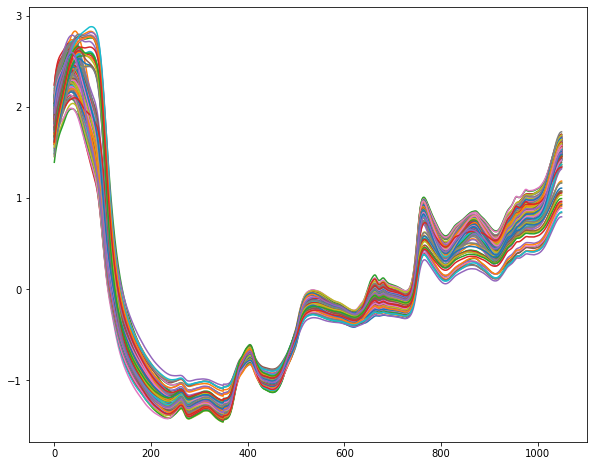

In [24]:
#Visualize spectra SNV
df_snv = snv(df.loc[:,'400':].to_numpy())
_= plt.plot(df_snv.T)

In [39]:
def smooth(spectra, filter_win=11, window_type='flat', mode='reflect'):
    """ Smooths the spectra using convolution.
    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        filter_win <float>: length of the filter window in samples.
        window_type <str>: filtering window to use for convolution (see scipy.signal.windows)
        mode <str>: convolution mode
    Returns:
        spectra <numpy.ndarray>: Smoothed NIR spectra.
    """

    if window_type == 'flat':
        window = np.ones(filter_win)
    else:
        window = scipy.signal.windows.get_window(window_type, filter_win)
    window = window / np.sum(window)

    for row in range(spectra.shape[0]):
        spectra[row,:] = nd.convolve(spectra[row,:], window, mode=mode)

    return spectra

In [40]:
def savgol(spectra, filter_win=15, poly_order=2, deriv_order=0, delta=1.0):
    """ Perform Savitzky–Golay filtering on the data (also calculates derivatives). This function is a wrapper for
    scipy.signal.savgol_filter.

    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        filter_win <int>: Size of the filter window in samples (default 11).
        poly_order <int>: Order of the polynomial estimation (default 3).
        deriv_order <int>: Order of the derivation (default 0).

    Returns:
        spectra <numpy.ndarray>: NIRS data smoothed with Savitzky-Golay filtering
    """
    return scipy.signal.savgol_filter(spectra, filter_win, poly_order, deriv_order, delta=delta, axis=1)

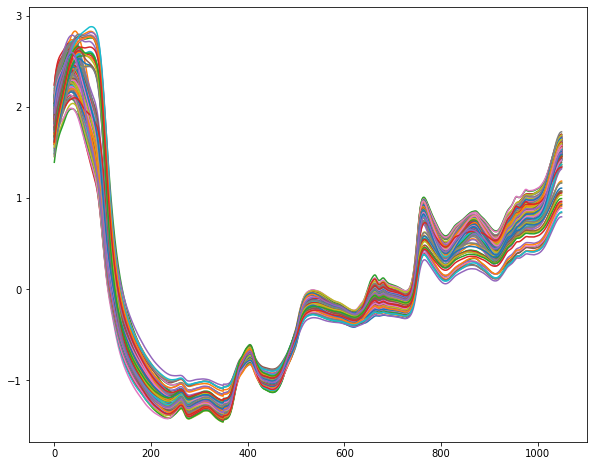

In [27]:
#Visualize spectra SNV
df_savgol = snv(df.loc[:,'400':].to_numpy())
_= plt.plot(df_savgol.T)

In [41]:
def derivate(spectra, order=1, delta=1):
    """ Computes Nth order derivates with the desired spacing using numpy.gradient.
    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        order <float>: Order of the derivation.
        delta <int>: Delta of the derivate (in samples).

    Returns:
        spectra <numpy.ndarray>: Derivated NIR spectra.
    """
    for n in range(order):
        spectra = np.gradient(spectra, delta, axis=1)
    return spectra

In [355]:
def preprocess(x):
    
  #Then compute first derivative
  #x = derivate(x,order=2)
  #Apply a Savitzky-Golay filter
  x = savgol(x)
    
  # Smooth data
  #x = smooth(x)

  #Then compute first derivative
  x = derivate(x)
    
  #Perform SNV
  #x = snv(x)
    
  #Detrend the signal
  #x = detrend(x)
  
  return x

In [356]:
def reduce_feature(X,y, num_features=300):
    """
    Reduce predictors by selecting the most informative features
    
    :Args:
        :x<numpy.ndrray>: the spectra data matrix
    :Returns:
        :<Numpy.ndrray>: reduced spectra
    """
    
    model = ExtraTreesRegressor()
    #y = y.to_numpy().reshape(-1,1)
    model.fit(X,y)
    #print(model.feature_names_in_)
    
    #Plot graph of feature importances for better visualization
    plt.figure(figsize=(7,5), dpi=100)
    feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    selected_features = feature_importances.nlargest(num_features)
    selected_features.plot(kind='barh')
    plt.show()
    
    return list(selected_features.index)
    

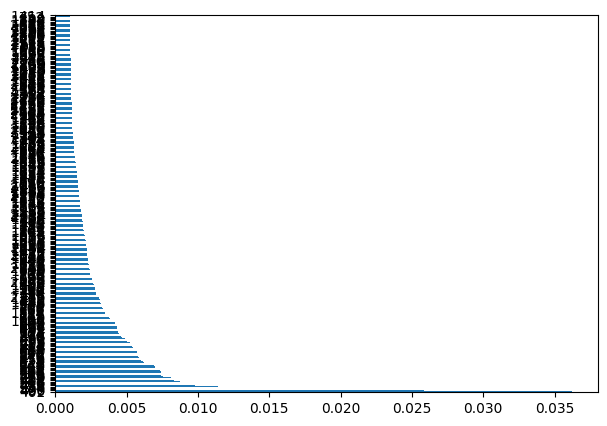

In [129]:
important_features = reduce_feature(df.loc[:,'400':],df["Oleic Acid"])

In [90]:
print(important_features)

['400', '410', '414', '402', '408', '420', '560', '412', '534', '404', '550', '416', '424', '530', '468', '586', '406', '514', '500', '588', '562', '492', '532', '526', '508', '582', '518', '542', '418', '570', '546', '540', '474', '718', '478', '594', '504', '712', '608', '696']


## Data Augmentation
Instead of correction of the baseline variations we use a special implementation of data augmentation. The idea is to simulate the expected form of irrelevant noise (here baseline offset and slope and overall spectrum intensity), and expect the neural network to either extract features robust to the variations, or figure out the best corrections during training. This way we can make more efficient use of the labelled dataset. The idea is similar to the image rotations and croppings done in image recognition training.

In [246]:
def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

In [247]:
def perform_dataaugmentation(X_train,y_train):
    shift = np.std(X_train)*0.1
    
    X_train_aug = np.repeat(X_train, repeats=100, axis=0)
    X_train_aug = dataaugment(X_train_aug, betashift = shift, slopeshift = 0.05, multishift = shift)

    y_train_aug = np.repeat(y_train, repeats=100, axis=0) #y_train is simply repeated
    
    return X_train_aug, y_train_aug

In [357]:

def load_data(fname=None, target=None, sensor=None):
  
  d = pd.read_csv(fname)
  

  # Convert Protein to float
  #d[target] = pd.to_numeric(d[target], errors='coerce', downcast='float')

  #Gather response and predictors in dataframe
  #d_corr = pd.concat([d["Species"].to_frame(), d[target].to_frame(), d.loc[:,'1350.155463':]], axis = 1)

  # Delete na
  #d_corr = d_corr.dropna(axis=0)

  #train = d[d['Set']=='Training']
  #test = d[d['Set']=='Validation']
  train, test = train_test_split(d, test_size=0.2, random_state=42, shuffle=True)
  train.to_csv('./results/peanut_to_krithika/train.csv',index=False)
  test.to_csv('./results/peanut_to_krithika/test.csv',index=False)
  #export shuffled data
  #train['Set']='Training'
  #test['Set']='Validation'
  #new=pd.concat([train,test],axis=0)
  #new.to_excel('./data/shuffled_multicereal_evt5_2021.xlsx',index=False)

  #Build predictors
  #if sensor=="hone_ag":
  x_train = train.loc[:,'400':]
  #x_train = train[important_features]
  #xcolnames = x_train.columns
  x_test = test.loc[:,'400':]
  #x_test = test[important_features]
  

  #Extract targets
  y_train = train[target]
  y_test = test[target]
    
  #Convert to numpy arrays
  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()
    
  #Data augmentation
  x_train, y_train = perform_dataaugmentation(x_train, y_train)

  #Create weighted predictors based on feature importance
  # x_train = weight_predictors(x_train,y_train)
  # x_test = weight_predictors(x_test,y_test)

  #Extract sample metadata from test set
  #if sensor=="hone_ag":
  train_set_metadata = train[["Genotype"]]
  test_set_metadata = test[["Genotype"]]
  
    

  #Apply preprocessing operations
  x_train = preprocess(x_train)
  x_test = preprocess(x_test)

  

  #Minmax Normalization of x and y
  xscaler = MinMaxScaler(feature_range=(0.1,0.9))
  x_train = xscaler.fit_transform(x_train)
  x_test = xscaler.transform(x_test)


  yscaler = MinMaxScaler(feature_range=(0.1,0.9))
  y_train = yscaler.fit_transform(y_train.reshape(-1,1))
  y_test = yscaler.transform(y_test.reshape(-1,1))
 


  ##Reshaping arrays
  x_train,x_test = np.expand_dims(x_train,axis=2),np.expand_dims(x_test,axis=2)
  #y_train,y_test = y_train.reshape(-1,1),y_test.reshape(-1,1)

      
  return x_train, y_train, x_test, y_test,yscaler, train_set_metadata, test_set_metadata

## Definition of ML and  DL models

In [341]:
def rfModel():
    rf_model = RandomForestRegressor()
    #Hyperparameter tuning using Randomized Search CV

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
    # max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 100]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 5, 10]
    
    random_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
    }
    
    #verbose parameter shows the details when training is on going
    rf_random = RandomizedSearchCV(rf_model, param_distributions=random_grid, scoring='neg_mean_squared_error', 
                                   n_iter=10, cv=5, random_state=42, verbose=3, n_jobs=-1)
    
    return rf_random


In [342]:
def denseModel(feature_count, x_dim):
    model = Sequential()
    model.add(Dropout(0.02, input_shape=(feature_count, x_dim)))
    model.add(GaussianDropout(0.3, input_shape=(feature_count, x_dim)))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Flatten())
    return model

In [343]:

def convModel(feature_count, x_dim):
    model = Sequential()
    model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    # model.add(GaussianDropout(0.2))
    # model.add(GaussianNoise(0.2))
    model.add(Conv1D (filters=32, kernel_size=5, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.02))
    
    model.add(Conv1D (filters=64, kernel_size=5, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.02))
    
    model.add(Conv1D (filters=128, kernel_size=5, strides=1, activation='relu'))
    model.add(SpatialDropout1D(0.02))
    model.add(BatchNormalization())
    
    model.add(Conv1D (filters=256, kernel_size=5, strides=1, activation='relu'))
    model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7), activation='relu'))


    model.add(Dense(1,activation='linear'))
    return model

In [358]:
def convModel2(feature_count,x_dim):
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(feature_count,x_dim)))
    #model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    model.add(Conv1D(filters=24, kernel_size=15, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=48,kernel_size=15 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=96,kernel_size=15, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))


    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(512, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    
    model.add(Dense(128, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.02))

    model.add(Dense(1,activation='linear'))
    return model


In [345]:
def convModel3(feature_count,x_dim):
    model = Sequential()
    model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    model.add(Conv1D(filters=16, kernel_size=5, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=36,kernel_size=15 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=56,kernel_size=20, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))


    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-8)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))


    
    model.add(Dense(128, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-8)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dense(1,activation='sigmoid'))
    return model

In [346]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32
activation='relu'

#The model
def convModel5(feature_count,x_dim):
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(feature_count,)))
    #First two is number of filter + kernel size
    model.add(Reshape((feature_count,x_dim) ))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    return model

In [347]:
def predict_and_show_metrics(trained_model, X_train, y_train, X_val, y_val):
    print('Saving model..')
    now = datetime.now()
    time = now.strftime("%Y-%m-%d")
    #savefn = target+'_DLmodel_'+sensor+time
    #training_model.save(os.path.join('./saved_models/',savefn),save_format='h5')
    print('Saving ended')
    #Use model to make predictions
    print('Making predictions')
    y_train_pred = trained_model.predict(X_train)
    y_val_pred = trained_model.predict(X_val)
    y_train_pred, y_val_pred = y_train_pred.reshape(-1,1), y_val_pred.reshape(-1,1)

    #Compute R2 
    r2_train = r2_score(y_train.flatten(),y_train_pred.flatten())
    r2_val = r2_score(y_val.flatten(),y_val_pred.flatten())

    #Recompute to original scale
    y_train_orig = yscaler.inverse_transform(y_train)
    y_train_pred_orig = yscaler.inverse_transform(y_train_pred)
    y_val_orig = yscaler.inverse_transform(y_val)
    y_val_pred_orig = yscaler.inverse_transform(y_val_pred)

    #Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_orig,y_train_pred_orig))
    rmse_val = np.sqrt(mean_squared_error(y_val_orig,y_val_pred_orig))

    #Compute RPD = std(reference data) / RMSE
    rpd_train = np.std(y_train_orig)/rmse_train
    rpd_val = np.std(y_val_orig)/rmse_val

    #Print metrics
    print("\n\n\n==============================")
    print("\n\n\n Evaluation metrics")
    print("\n\nR2 train: ",r2_train)
    print("RMSE train: ",rmse_train)
    print("RPD train: ",rpd_train)
    print("R2 val: ",r2_val)
    print("RMSE val: ",rmse_val)
    print("RPD val: ",rpd_val)
    print("\n\n\n==============================")
    
    return y_train_orig,y_train_pred_orig,y_val_orig,y_val_pred_orig

# Prepare data and train the models

In [348]:
fn = "./CleanedData/315_GN_FA.csv"

In [349]:
ts= ['Linoleic Acid', 'Oleic Acid', 'Palmitic Acid', 'Stearic Acid']

In [359]:
target = 'Oleic Acid'
sensor = 'Foss'

In [366]:
X_train, y_train, X_val, y_val,yscaler, train_metadata, test_meta = load_data(fname=fn, target =target)

In [367]:
print(X_train.shape,X_val.shape)

(25200, 1050, 1) (63, 1050, 1)


### Train ML model

In [186]:
rf = rfModel()
X_train_ml = np.squeeze(X_train)
X_val_ml = np.squeeze(X_val)
rf.fit(X_train_ml,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=3)

In [187]:
y_train_orig,y_train_pred_orig,y_val_orig,y_val_pred_orig = predict_and_show_metrics(rf, X_train_ml, y_train, X_val_ml, y_val)

Saving model..
Saving ended
Making predictions






 Evaluation metrics


R2 train:  0.8924663274672076
RMSE train:  1.9791413568685232
RPD train:  3.049493843202419
R2 val:  0.8409186788656795
RMSE val:  3.219170177544374
RPD val:  2.5072082344049007





### Train DL model

In [368]:
NIRS_feature_count = X_train.shape[1]
NIRS_dim = X_train.shape[2]

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=0, min_delta=1e-6, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(["GPU:0"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    training_model = convModel5(NIRS_feature_count, NIRS_dim)
    print("-Number of parameters: ", training_model.count_params())
    #Save model architecture
    #plot_model(training_model, to_file='./results/model_architecture.png', show_shapes=True, show_layer_names=True)
    #Compile model
    print('Model compilation\n')
    opt = keras.optimizers.Adam(lr=3e-4)
    training_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer=opt)
    #training_model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))



print('Start model training...')
history = training_model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size=16, 
                    validation_data=(X_val,y_val), 
                    verbose=0, 
                    callbacks=[reduce_lr_loss,earlyStopping])
print('Training ended')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
-Number of parameters:  2155033
Model compilation

Start model training...
Training ended


In [369]:
#Show metrics
y_train_orig,y_train_pred_orig,y_val_orig,y_val_pred_orig = predict_and_show_metrics(training_model, X_train, y_train, X_val, y_val)

Saving model..
Saving ended
Making predictions






 Evaluation metrics


R2 train:  0.996513523766653
RMSE train:  0.35636723474159815
RPD train:  16.935842564129377
R2 val:  0.8597412321950004
RMSE val:  3.0227299408258053
RPD val:  2.6701459062151347





## Export outputs


In [294]:
from datetime import datetime

def export_results(y_train_orig,y_train_pred_orig,train_metadata,
                   y_val_orig,y_val_pred_orig,test_meta,model_type='CNN',sensor='Foss'):
    
    
    dtObj = datetime.utcnow()
    time = dtObj.strftime("%d-%b-%Y_%H-%M-%S")
    
    if model_type !='CNN':
        #Calibration
        exports_cal = {'Genotype':train_metadata["Genotype"],'ytrain':y_train_orig.flatten(),'ytrain_pred':y_train_pred_orig.flatten()}
        exports_cal = pd.DataFrame(exports_cal)
        filename_cal = target+'_cal_'+model_type+'_'+sensor+'_'+time+'_.xlsx'
        exports_cal.to_excel(os.path.join('./results/peanut_to_krithika/',filename_cal),index=False)

    #Validation
    exports_val = {'Genotype':test_meta["Genotype"],'yval':y_val_orig.flatten(),'yval_pred':y_val_pred_orig.flatten()}
    exports_val = pd.DataFrame(exports_val)
    filename_val = target+'_val_'+model_type+'_'+sensor+'_'+time+'_.xlsx'
    exports_val.to_excel(os.path.join('./results/peanut_to_krithika/',filename_val),index=False)

In [295]:
export_results(y_train_orig,y_train_pred_orig,train_metadata,y_val_orig,y_val_pred_orig,test_meta)

<AxesSubplot:xlabel='yval'>

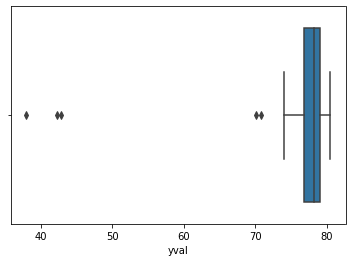

In [189]:
import seaborn as sns
sns.boxplot('yval',data=exports_val)

## Saving model

In [374]:
def save_model(model, model_type,target=None,sensor=None,crop=None):
    now = datetime.now()
    time = now.strftime("%Y-%m-%d")
    #fn = crop + target + model_type + sensor + time
    fn = '_'.join([crop, target, model_type, sensor, time])
    save_dir = "./saved_models"
    
    if model_type=='ML':
        filename = fn + ".pkl"
        filename = os.path.join(save_dir,filename)
        # Open a file where you want to store the data
        file = open(filename, "wb")

        # Dump information into the file
        pickle.dump(model, file)
    
    elif model_type == 'DL':
        filename = os.path.join(save_dir,fn)
        model.save(filename,save_format='h5')

        

In [375]:
save_model(training_model,model_type='DL',target='OleicAcid',sensor='Foss',crop='Peanut')

## Ridge regression

In [139]:
#X,y = df.loc[:,'400':],df['Oleic Acid']
X,y = X_train.squeeze() , y_train

In [141]:
parameters = {'alpha':np.logspace(-4, -3.5, 50)}

ridge= GridSearchCV(Ridge(), parameters, scoring='r2', cv=10)
 
# Fit to the data
ridge.fit(X, y)
 
#Get the optimised value of alpha
print('Best parameter alpha = ', ridge.best_params_['alpha'])
print('R2 calibration: %5.3f'  % ridge.score(X,y))
 
# Run a ridge regression with the optimised value
ridge1 = Ridge(alpha=ridge.best_params_['alpha'])
y_cv = cross_val_predict(ridge1, X, y, cv=10)
 
# y_cv=predicted
score_cv = r2_score(y, y_cv)
mse_cv = mean_squared_error(y, y_cv)
print('R2 CV (Ridge): %5.3f'  % score_cv)
print('MSE CV (Ridge): %5.3f' % mse_cv)

Best parameter alpha =  0.00031622776601683794
R2 calibration: 0.984
R2 CV (Ridge): 0.433
MSE CV (Ridge): 0.007


## Elastic model

In [147]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='r2', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)

#Get the optimised value of alpha
print('Best parameter alpha = ', search.best_params_['alpha'])
print('R2 calibration: %5.3f'  % search.score(X,y))
 
# Run a ridge regression with the optimised value
elnet = ElasticNet(alpha=search.best_params_['alpha'], l1_ratio=search.best_params_['l1_ratio'])
y_cv = cross_val_predict(elnet, X, y, cv=10)
 
# y_cv=predicted
score_cv = r2_score(y, y_cv)
mse_cv = mean_squared_error(y, y_cv)
print('R2 CV (Ridge): %5.3f'  % score_cv)
print('MSE CV (Ridge): %5.3f' % mse_cv)


MAE: -0.229
Config: {'alpha': 0.1, 'l1_ratio': 0.02}


Best parameter alpha =  0.1
R2 calibration: 0.146
R2 CV (Ridge): 0.073
MSE CV (Ridge): 0.011


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [4, 5],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [6, 7],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9],
       [8, 9]])